# ECO6128 Tutorial - Text Mining Demo

ChnSentiCorp_htl_all dataset downloaded from: https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb
This dataset has over 7000 hotel reviews, over 5000 positive reviews and over 2000 negative reviews. The data looks roughly like the following: The first column is the table, which takes 0 or 1. 0 means negative reviews, 1 means positive reviews. The second column is the content of the comments. In this small demo, 20 positive and 20 negative comments were randomly copied as data.

Created by *Xinghao YU*, March 18th, 2023

*Copyright@Chinese University of Hong Kong, Shenzhen*

In [1]:
import jieba
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)

## Segmentation

In [2]:
pd_all = pd.read_csv('./ChnSentiCorp_htl_all.csv')

print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

pd_all.sample(10, random_state=10086)

评论数目（总体）：7766
评论数目（正向）：5322
评论数目（负向）：2444


,label,review
1353,1,入住的是商务大床房，是最贵的房型了。但一打开门，天，温差起码15度！房间里竟然是壁挂空调！因...
2663,1,"酒店服务人员服务好,交通方便,价格适中,房间一般,缺点是早餐比较差,还要10元/人."
3821,1,"本次入住的是豪华房,床很大而且很舒适,房间面积也很大,灯光协调,落地玻璃窗视野宽广,可以看到..."
6614,0,告诉大家这个饭店千万别去。这说的是标准的“5”星饭店，不过是连4形都答不到的地方，里面除了饭...
7148,0,"1.收了包天的10元话费,却打不出电话;2.装牙刷的盒子是一个空盒子3.不提供购物袋"
2509,1,非常不错的酒店，地理位置也不错，性价比很高！
5067,1,"服务非常好,希望不是正好赶上奥运才这样.去哪里都有人带路.宾至如归啊!早餐还算丰富,门口也有..."
3832,1,地方还可以房间有点脏我住的是B212但还行就是卧室里没电视不爽其他还可以早餐没时间吃这个地段...
5781,0,在携程预定酒店这么多次，遇到的最烂的酒店。住在行政豪华房，早上7点半起来连洗澡的热水也没有。...
7059,0,第一次评价。为什么呢。因为该酒店结算的时候多收了我50元钱。说是消费了：一把刮刀15元，另外...


In [45]:
pd_sample = pd.concat([pd_all[pd_all.label==1].sample(50, random_state=10086),
                      pd_all[pd_all.label==0].sample(50, random_state=10086)])
pd_sample.head(5)

,label,review
1925,1,环境安静，离火车站近。房间布置不错，早餐以中餐为主，丰富。下次接着住
4586,1,酒店的位置较好，出了火车站坐8路车就能到酒店，酒店后门就是洋人街，交通很方便。装修也很好，特...
250,1,通过携程预订，入住3天，感觉价格和房间差距较大，房间陈旧、卫生间较小、特别是电视机那叫一个破...
2480,1,很不错，大堂很豪华，甚至太豪华了。房间很大，卫生间很好。就是早餐差了一点。为什么菜不再多一点...
4337,1,很舒适的酒店，软硬设施都不错。交通也比较方便，就是周围吃饭的地方不太多，还好离SM广场满近的...


In [46]:
# 将文档中的每一个评论分为一行
file_line = []
count = 0  # 统计行数
for line in range(0, pd_sample.shape[0]):
    file_line.append(pd_sample.iloc[line]['review'])
    count += 1
print("There are %d rows in total." % count)

There are 100 rows in total.


In [47]:
file_line

['环境安静，离火车站近。房间布置不错，早餐以中餐为主，丰富。下次接着住',
 '酒店的位置较好，出了火车站坐8路车就能到酒店，酒店后门就是洋人街，交通很方便。装修也很好，特别是前台的白族小姐态度超好，早餐也很丰富。是个不错的酒店，下次去的话还会去住。',
 '通过携程预订，入住3天，感觉价格和房间差距较大，房间陈旧、卫生间较小、特别是电视机那叫一个破哦，估计成都的招待所都没有这样的电视机了。早餐不错，服务没有体会到。房间价格在158元/间应该差不多了。',
 '很不错，大堂很豪华，甚至太豪华了。房间很大，卫生间很好。就是早餐差了一点。为什么菜不再多一点呢？早餐很重要。',
 '很舒适的酒店，软硬设施都不错。交通也比较方便，就是周围吃饭的地方不太多，还好离SM广场满近的。酒店还给通过携程入住的旅客送上了一个毛巾礼盒，呵呵，有点意外的惊喜~~~',
 '酒店现在只送早餐了，中餐晚餐是10元的自助餐，相当不错。服务还可以，结账也很快。',
 '还不错的酒店，虽然有些旧，日方也撤资了。可能南京本来也不大的原因吧，从酒店去新街口等地方都不远。服务也很好。',
 '性价比还是不错的,房间也很干净,周围也比较安静,唯一的缺点就是房间有点小,我住的大床房间',
 '挺不错的，房间很敞亮，没有压抑感，看上去很干净，只是洗澡的地方有点小，不过水很大。',
 '酒店有点偏，（没有地铁站），19：30后就没有shuttlebus了。大堂很小，也没有什么设施。不过，房间很好，也有海景。',
 '已经多次给客户订这个酒店了,这次是自己第一次去.房间非常好,虽然只是标准大床房,房间也不大,但是设施齐全,很舒服,干净整洁.唯一不太满意的是房间的暖气太热了,尽管我已关闭了房间内的中央空调的开关,但温度还是很高,看来这个开关不能控制房间的温度.自助早餐比较一般,不是很丰盛.希望房价能包含早餐.',
 '该酒店服务较好,位置也较优越,但出租车大部分不知道怎么走.',
 '房间不大，但相当舒适．距离热闹的酒吧集中区也很近，方便．环境干净＼清净，适合睡大觉．服务中规中矩，此次通过携程订房也很快捷＼省心．住的时间有限，两晚，但总体感觉不错，下次再到丽江，相信这也是下榻的首选补充点评2008年7月5日：没有给５分，不是因为有任何不满，而是完全出于个人对客栈短时间内获得的认识，也是出于希望客栈的服务能够一直保持

In [48]:
# 在过程中动态添加用户字典
jieba.suggest_freq('碧海蓝天', True)
# 也可以自己先形成一个文档例如mydict.txt
# 用法： jieba.load_userdict(file_name) # file_name 为文件类对象或自定义词典的路径
# 词典格式：一个词占一行；每一行分三部分：词语、词频（可省略）、词性（可省略），用空格隔开，顺序不可颠倒。
# file_name 若为路径或二进制方式打开的文件，则文件必须为 UTF-8 编码。
# 使用 add_word(word, freq=None, tag=None) 和 del_word(word) 可在程序中动态修改词典。

# 使用jieba开始分词
# file_userDict = 'dict.txt'  # 自定义的词典 目前还没有
# jieba.load_userdict(file_userDict)
res = []
for i in range(len(file_line)):
    sentence_seged = jieba.cut(file_line[i].strip())
    res.append(' '.join(sentence_seged))
print('Segmentation Complete!')
for i in range(len(res)):
    print(res[i])

Segmentation Complete!
环境 安静 ， 离 火车站 近 。 房间 布置 不错 ， 早餐 以 中餐 为主 ， 丰富 。 下次 接着 住
酒店 的 位置 较 好 ， 出 了 火车站 坐 8 路车 就 能 到 酒店 ， 酒店 后门 就是 洋人街 ， 交通 很 方便 。 装修 也 很 好 ， 特别 是 前台 的 白族 小姐 态度 超好 ， 早餐 也 很 丰富 。 是 个 不错 的 酒店 ， 下次 去 的话 还会 去 住 。
通过 携程 预订 ， 入住 3 天 ， 感觉 价格 和 房间 差距 较大 ， 房间 陈旧 、 卫生间 较 小 、 特别 是 电视机 那 叫 一个 破 哦 ， 估计 成都 的 招待所 都 没有 这样 的 电视机 了 。 早餐 不错 ， 服务 没有 体会 到 。 房间 价格 在 158 元 / 间 应该 差不多 了 。
很 不错 ， 大堂 很 豪华 ， 甚至 太 豪华 了 。 房间 很大 ， 卫生间 很 好 。 就是 早餐 差 了 一点 。 为什么 菜 不再 多一点 呢 ？ 早餐 很 重要 。
很 舒适 的 酒店 ， 软硬 设施 都 不错 。 交通 也 比较 方便 ， 就是 周围 吃饭 的 地方 不太多 ， 还好 离 SM 广场 满近 的 。 酒店 还给 通过 携程 入住 的 旅客 送上 了 一个 毛巾 礼盒 ， 呵呵 ， 有点 意外 的 惊喜 ~ ~ ~
酒店 现在 只 送 早餐 了 ， 中餐 晚餐 是 10 元 的 自助餐 ， 相当 不错 。 服务 还 可以 ， 结账 也 很快 。
还 不错 的 酒店 ， 虽然 有些 旧 ， 日方 也 撤资 了 。 可能 南京 本来 也 不 大 的 原因 吧 ， 从 酒店 去 新街口 等 地方 都 不远 。 服务 也 很 好 。
性价比 还是 不错 的 , 房间 也 很 干净 , 周围 也 比较 安静 , 唯一 的 缺点 就是 房间 有点 小 , 我 住 的 大床 房间
挺不错 的 ， 房间 很 敞亮 ， 没有 压抑感 ， 看上去 很 干净 ， 只是 洗澡 的 地方 有点 小 ， 不过 水 很大 。
酒店 有点 偏 ， （ 没有 地铁站 ） ， 19 ： 30 后 就 没有 shuttlebus 了 。 大堂 很小 ， 也 没有 什么 设施 。 不过 ， 房间 很 好 ， 也 有 海景 。
已经 多

In [49]:
# 加载停用词列表
f_stop = open('./stop_word.txt')  # 自己的中文停用词表
sw = [line.strip() for line in f_stop]
f_stop.close()
# sw

In [50]:
word_list_seg = []
for i in range(len(res)):
    stopwords = sw
    outstr = ''
    for word in res[i].split():
        # print('word:', word)
        if word not in stopwords:
            if word != '/t':
                outstr += word
                outstr += " "
    print('Sentence %d, outstr: %s' % (i ,outstr))
    word_list_seg.append(outstr)
print('_______________________')
print('Stop Words Removal Complete!')
print(len(word_list_seg))

# for i in range(len(word_list_seg)):
#    print(word_list_seg[i])

Sentence 0, outstr: 环境 安静 火车站 房间 布置 不错 早餐 中餐 下次 住 
Sentence 1, outstr: 酒店 位置 火车站 坐 路车 酒店 酒店 后门 洋人街 交通 装修 特别 前台 白族 小姐 态度 超好 早餐 不错 酒店 下次 还会 住 
Sentence 2, outstr: 携程 预订 入住 天 感觉 价格 房间 差距 较大 房间 陈旧 卫生间 特别 电视机 破 估计 成都 招待所 电视机 早餐 不错 服务 体会 房间 价格 158 间 
Sentence 3, outstr: 不错 大堂 豪华 太 豪华 房间 很大 卫生间 早餐 差 一点 菜 多一点 早餐 
Sentence 4, outstr: 舒适 酒店 软硬 设施 不错 交通 吃饭 地方 不太多 还好 SM 广场 满近 酒店 还给 携程 入住 旅客 送上 毛巾 礼盒 意外 惊喜 
Sentence 5, outstr: 酒店 送 早餐 中餐 晚餐 自助餐 不错 服务 结账 很快 
Sentence 6, outstr: 不错 酒店 旧 日方 撤资 南京 本来 原因 酒店 新街口 地方 不远 服务 
Sentence 7, outstr: 性价比 不错 房间 干净 安静 唯一 缺点 房间 住 大床 房间 
Sentence 8, outstr: 挺不错 房间 敞亮 压抑感 干净 洗澡 地方 水 很大 
Sentence 9, outstr: 酒店 偏 地铁站 shuttlebus 大堂 很小 设施 房间 海景 
Sentence 10, outstr: 客户 订 酒店 第一次 房间 标准 大床 房 房间 设施 齐全 舒服 干净 整洁 唯一 不太 满意 房间 暖气 太热 关闭 房间内 中央空调 开关 温度 高 开关 控制 房间 温度 自助 早餐 丰盛 希望 房价 包含 早餐 
Sentence 11, outstr: 酒店 服务 位置 优越 出租车 大部分 走 
Sentence 12, outstr: 房间 舒适 距离 热闹 酒吧 集中区 环境 干净 ＼ 清净 适合 睡大觉 服务 中规中矩 携程 订房 快捷 ＼ 省心 住 时间 有限 两晚 总体 感觉 不错 下次 丽江 下榻 首选 补充 点评 年 月 日 分 客栈 短时间 希望 客栈 服务 水准 轻易 商业化 潮流

Sentence 85, outstr: 酒店 外观 不错 房间内 物品 实在 太 陈旧 席梦思床 高低不平 躺 滚 致电 管家 部后 很快 一位 服务生 情况 动作 熟练地 干开 被子 枕头 床单 行李 桌上 扔 席梦思床 翻个 身 床单 一铺 动作 连贯 一气呵成 看得出来 事情 服务生 做 浴室 浴巾 磨损 薄 酒店 里 早就 客人 拖鞋 象纸 多久 梳子 电视频道 非常少 HBO 想 优点 酒店 交通 多条 公交车 站点 饭店 吃饭 不成问题 
Sentence 86, outstr: 三星级 大堂 零星 级 房间 三星级 卫生 早餐 尚可 
Sentence 87, outstr: 宾馆 神奇 早上 点多 放 大声 背景音乐 晚上 点多 一张 CD 发疯 朋友 开玩笑 说 宾馆 入住 客人 发 耳塞 客人 发疯 第二天 搬家 天 宾馆 宣传 照片 不符 照片 房间 超 豪华 五星 水准 星 水准 空调 发出 噪音 制热 房间 门 关不上 宾馆 解释 说 冬天 门 缩水 关上 电视机 说 平遥 星级 真的 想象 差距 早餐 咖啡 速溶 咖啡 差 牛奶 掺水 房价 780 去不去 住 搬 天元 奎去 价格 便宜 服务生 特别 云锦 诚在 排场 挺大 口碑 不怎么样 政府 官员 太 适合 地方 没住 差 宾馆 
Sentence 88, outstr: 同事 一晚 雾都 宾馆 月 日 点 入主 月 日 外出 点 回房 房卡 开门 服务员 开门 先要 查看 身份证件 入主 时 提交 证件 房卡 进门 宾馆 服务 查 身份 开门 大堂 经理 狡辩 说 电池 房间 房卡 没电 可能性 说 奥运 期间 保卫 说 合法 入主 结帐 违法行为 讲 违法 国家 公安部门 入住 时间 自由 出入 希望 携程 满意 答复 宾馆 态度 服务 成问题 
Sentence 89, outstr: 服务 招待所 水平 网络 不好 值得 推荐 
Sentence 90, outstr: 一家 星级 酒店 达 不到 房间 设施 陈旧 简陋 服务态度 象 国营企业 皮笑肉不笑 心寒 餐厅 菜 难吃 贵 受不了 上网 收费 速度 不快 携程 房价 高 吓人 下次 再住 酒店 
Sentence 91, outstr: 酒店 恼火 CTRIP 里查 价格 全适 入住 象是 宰割 冤大头 房间 电器

## SVD and LSI

In [77]:
# raw documents to tf-idf matrix: 
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)
# SVD to reduce dimensionality: 
svd_model = TruncatedSVD(n_components=5,       
                         algorithm='randomized',
                         n_iter=10)
# pipeline of tf-idf + SVD, fit to and applied to documents:
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
dc_matrix = svd_transformer.fit_transform(word_list_seg)
# dc_matrix can later be used to compare documents, compare words, or compare queries with documents

In [78]:
dc_matrix.shape

(100, 5)

In [79]:
svd_model.components_.shape

(5, 1375)

In [80]:
sum(svd_model.explained_variance_ratio_)

0.08353834585071696

In [81]:
document_concept_matrix = pd.DataFrame(dc_matrix)

d = []
for row in range(0, document_concept_matrix.shape[0]):
    d.append(f'd{row+1}')
document_concept_matrix.index = d

tc_matrix = np.dot(svd_model.components_.T, np.diag(svd_model.singular_values_))
term_concept_matrix = pd.DataFrame(tc_matrix)
term_concept_matrix.index = vectorizer.get_feature_names()

In [82]:
document_term = pd.concat([document_concept_matrix, term_concept_matrix])
document_term

,0,1,2,3,4
d1,0.352528,-0.109446,0.284036,0.466068,-0.060419
d2,0.405689,0.314492,0.152246,0.105943,-0.051339
d3,0.340026,-0.224701,0.014351,-0.075341,-0.031984
d4,0.329382,-0.319236,-0.242995,0.310309,0.258762
d5,0.219035,0.177358,-0.027293,-0.087051,0.015390
...,...,...,...,...,...
麻烦,0.029710,0.004187,-0.010379,-0.028359,-0.031604
黄色,0.009461,-0.006050,0.009216,-0.002904,0.008875
黄金周,0.031275,-0.000456,0.027928,-0.045805,0.034265
黑色,0.006679,-0.002267,-0.002923,0.002844,0.001123


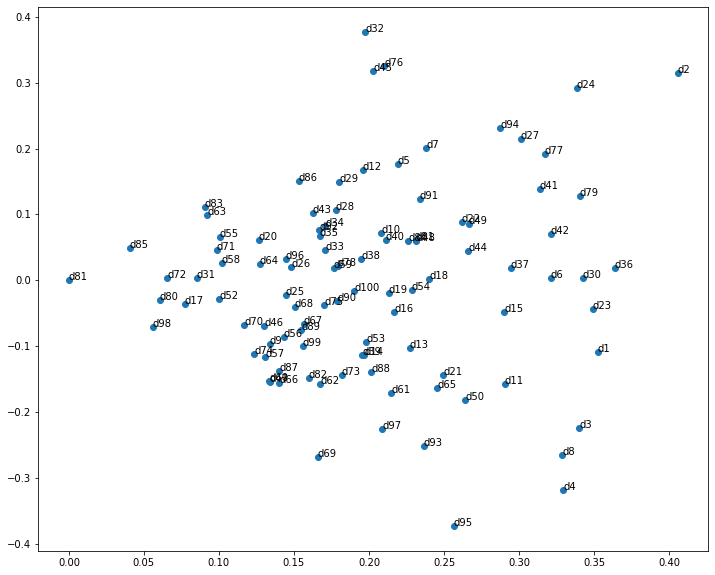

In [83]:
# plot all document-concept vectors
plt.scatter(x = document_concept_matrix[0], y = document_concept_matrix[1])
# add labels to all points
for idx, row in document_concept_matrix.iterrows(): 
    plt.text(row[0], row[1], idx)

## Text Similarity

**Seaborn** is a library for making statistical graphics in Python. It builds on top of *matplotlib* and integrates closely with pandas data structures.

**Seaborn** helps you explore and understand your data. Its plotting functions operate on *dataframes* and arrays containing whole datasets and internally perform the necessary semantic mapping and statistical aggregation to produce informative plots. Its dataset-oriented, declarative *API* lets you focus on what the different elements of your plots mean, rather than on the details of how to draw them.

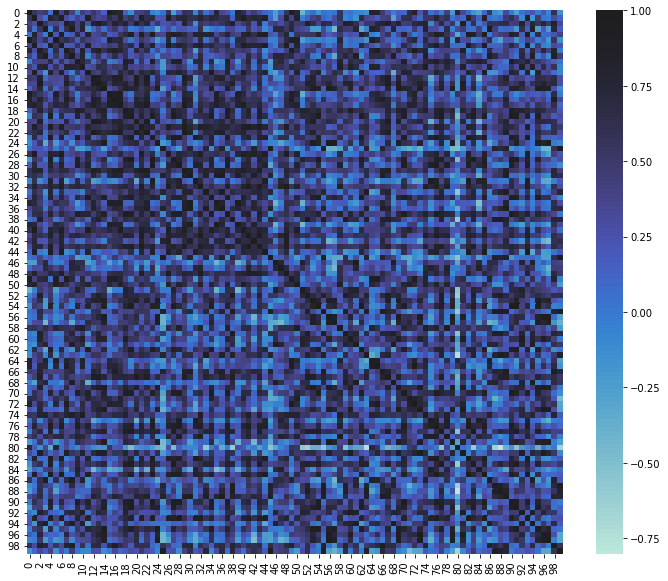

In [84]:
def similar_matrix(truncated_text_vector, similarity_function):
    le = len(truncated_text_vector)
    matrix = [[similarity_function([truncated_text_vector[i], truncated_text_vector[j]])[1, 0] 
               for j in range(le)] for i in range(le)]
    sns.heatmap(matrix, center=1, annot=False)
    plt.show()

similar_matrix(dc_matrix, cosine_similarity)

## Text Clustering

In [85]:
clf = KMeans(n_clusters=3)

kmeans_results = clf.fit_predict(dc_matrix)
kmeans_results

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0,
       2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2,
       2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2], dtype=int32)

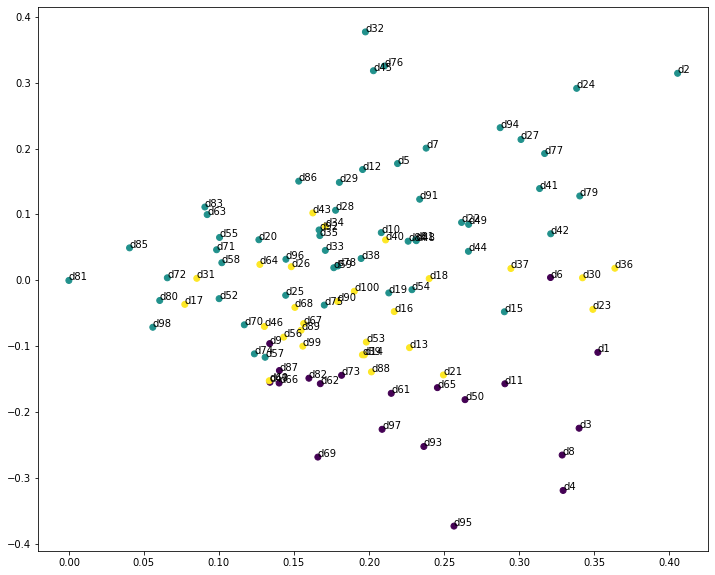

In [86]:
plt.scatter(x = document_concept_matrix[0], y = document_concept_matrix[1],
           c = kmeans_results)
for idx, row in document_concept_matrix.iterrows(): 
    plt.text(row[0], row[1], idx)